In [25]:
import os, sys, random
sys.path.append('..')
import numpy as np
import torch
import torch.nn as nn
from time import time
from tqdm import tqdm, trange
from termcolor import cprint
# import wandb

from omegaconf import DictConfig, open_dict
import hydra
from hydra.utils import get_original_cwd

from constants import device

from torch.utils.data import DataLoader, RandomSampler, BatchSampler

from meg_decoding.models import get_model, Classifier
from meg_decoding.utils.get_dataloaders import get_dataloaders, get_samplers
from meg_decoding.utils.loss import *
from meg_decoding.dataclass.god import GODDatasetBase, GODCollator
from meg_decoding.utils.loggers import Pickleogger
from meg_decoding.utils.vis_grad import get_grad
from torch.utils.data.dataset import Subset
from meg_ssl.dataclass import parse_dataset
from omegaconf import OmegaConf
from meg_ssl.models.image_encoder import get_image_encoder
import wandb
from meg_ssl.utils.image_preprocess import numpy2image
import tqdm
import scipy.io
from hydra import initialize, compose


In [26]:
def get_dataset(cfg:OmegaConf):
    dataset_names:dict = cfg.dataset_name
    dataset_yamls:dict = cfg.dataset_yaml
    num_trial_limit:dict = cfg.total_limit
    preproc_config:OmegaConf = cfg.preprocess
    h5_root:str = cfg.h5_root
    image_preprocs:list = []
    meg_preprocs:list = []
    only_meg:bool = False
    on_memory:bool = True #False
    dataset_dict:dict = parse_dataset(dataset_names, dataset_yamls, preproc_config, num_trial_limit, 
                                      h5_root, image_preprocs, meg_preprocs, only_meg, on_memory)
    
    return dataset_dict['train'], dataset_dict['val']

def get_models(args):
    with initialize(config_path='../meg_ssl/task_configs/model'):
        args.image_encoder = compose(args.image_encoder)
    with initialize(config_path='../meg_ssl/ssl_configs/preprocess'):
        args.preprocess = compose(args.preprocess)
    
    image_encoder, image_processor = get_image_encoder(args.image_encoder.name, args.image_encoder.parameters)
    image_encoder.eval().to(device)
    
    brain_encoder = get_model(args).to(device).eval() 
    
    weight_path = os.path.join(args.save_root, 'weights', 'model_last.pt')
    brain_encoder.load_state_dict(torch.load(weight_path))
    return image_encoder, image_processor, brain_encoder
    
# collect image feature
def get_features(dataset):
    image_features = []
    eeg_features = []
    for data in tqdm.tqdm(dataset):
        eeg, image = data
        eeg = torch.from_numpy(eeg).unsqueeze(0).to(device)
        image = numpy2image(image)
        image = image_processor(image)
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            Y = image_encoder.encode_image(image).to(torch.float)
            Y = Y - normalize_mean_Y
            Y = Y / normalize_std_Y
            Z = brain_encoder(eeg, None)
        image_features.append(Y)
        eeg_features.append(Z)

    image_features = torch.cat(image_features, axis=0)
    eeg_features = torch.cat(eeg_features, axis=0)
    return image_features, eeg_features


def calc_similarity(x, y):
    batch_size = len(x)
    gt_size = len(y)

    similarity = torch.empty(batch_size, gt_size).to('cuda')
    for i in range(batch_size):
        for j in range(gt_size):
            similarity[i, j] = (x[i] @ y[j]) / max((x[i].norm() * y[j].norm()), 1e-8)
    return similarity.cpu().numpy()

def evaluate(Z, Y, index = None):
    # Z: (batch_size, 512)
    # Y: (gt_size, 512)
    binary_confusion_matrix = np.zeros([len(Z), len(Y)])
    similarity = calc_similarity(Z, Y)
    acc_tmp = np.zeros(len(similarity))
    for i in range(len(similarity)):
        if index is None:
            index_ = i
        acc_tmp[i] = np.sum(similarity[i,:] < similarity[i,index_]) / (len(Y)-1)
        binary_confusion_matrix[i,similarity[i,:] < similarity[i,index_]] = 1 
        binary_confusion_matrix[i,similarity[i,:] > similarity[i,index_]] = -1 
    similarity_acc = np.mean(acc_tmp)
    print('Similarity Acc', similarity_acc)
    return similarity_acc, binary_confusion_matrix

def get_test_labels():
    dirname = '/work/project/MEG_GOD/GOD_dataset/sbj01/labels/'
    labels = []
    for i in range(1,7):
        filepath = os.path.join(dirname, f'val_{i}.mat')
        matdata = scipy.io.loadmat(filepath)
        label = matdata['vec_index'][0] 
        labels.append(label)
    labels = np.concatenate(labels, axis=0)
    return labels


def aggregate_same_label(eegs, images, labels):
    assert len(eegs) == len(labels)
    assert len(images) == len(labels)
    unique_label_ids = np.unique(labels)
    new_eegs = []
    new_images = []
    for i in unique_label_ids:
        indices = np.where(labels==i)
        new_eegs.append(eegs[indices].mean(0))
        new_images.append(images[indices].mean(0))
    return torch.stack(new_eegs, axis=0), torch.stack(new_images, axis=0), unique_label_ids

In [27]:
with initialize(version_base=None, config_path="../meg_ssl/task_configs/"):
    args = compose(config_name='regression_eegnet_deep')
    
args.dataset_name.train = args.dataset_name.val
args.dataset_name.val.GOD = 'sbj_1-val-session_all' # args.dataset_name.val.GOD.replace('train', 'val')
args.ch_region_path = args.ch_region_path.replace('./', '../')
args.montage_path = args.montage_path.replace('./', '../')

if not os.path.exists(os.path.join(args.save_root, 'eval_results')):
    os.makedirs(os.path.join(args.save_root, 'eval_results'))
    
    
normalize_mean_X = torch.from_numpy(np.load('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/mean_X.npy')).to(device)
normalize_mean_Y = torch.from_numpy(np.load('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/mean_Y.npy')).to(device)
normalize_std_X = torch.from_numpy(np.load('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/std_X.npy')).to(device)
normalize_std_Y = torch.from_numpy(np.load('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/std_Y.npy')).to(device)

classifier = Classifier(args)

# ---------------
#      Loss
# ---------------
loss_func = CLIPLoss(args).to(device) # torch.nn.MSELoss(reduction="mean") #CLIPLoss(args).to(device)
loss_func.eval()

image_encoder, image_processor, brain_encoder = get_models(args)
val_dataset, test_dataset = get_dataset(args)

/tmp/ipykernel_28042/3832526577.py:17: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/task_configs/model'):
/tmp/ipykernel_28042/3832526577.py:19: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path='../meg_ssl/ssl_configs/preprocess'):


model select:  eegnet_deep
ROI:  ['occipital/left', 'occipital/right', 'frontal/left', 'frontal/right', 'temporal/left', 'temporal/right', 'parietal/left', 'parietal/right', 'central/left', 'central/right']
channel (-1 is done because matlab starts from 1):  [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 38, 43, 45, 46, 47, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 78, 87, 106, 108, 109, 110, 111, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 61, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 112, 113, 114, 115, 117, 118, 119, 120, 121, 123, 125, 17, 19, 20, 21, 22, 23, 29, 59, 60, 63, 139, 140, 141, 142, 143, 80, 81, 82, 85, 86, 88, 116, 124, 126, 155, 156, 157, 159, 12, 13, 14, 15, 16, 18, 24, 25, 26, 27, 28, 30, 31, 58, 62, 158, 74, 77, 79, 83, 84, 89, 90, 91, 92, 93, 94, 95, 107, 122, 127]
num channels:  160
=================GOD===========

band path filter: 0.5-120
resample 1000 to 240 Hz
ROI:  ['occipital/left', 'occipital/right', 'frontal/left', 'frontal/right', 'temporal/left', 'temporal/right', 'parietal/left', 'parietal/right', 'central/left', 'central/right']
channel (-1 is done because matlab starts from 1):  [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 38, 43, 45, 46, 47, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 78, 87, 106, 108, 109, 110, 111, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 44, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 61, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 112, 113, 114, 115, 117, 118, 119, 120, 121, 123, 125, 17, 19, 20, 21, 22, 23, 29, 59, 60, 63, 139, 140, 141, 142, 143, 80, 81, 82, 85, 86, 88, 116, 124, 126, 155, 156, 157, 159, 12, 13, 14, 15, 16, 18, 24, 25, 26, 27, 28, 30, 31, 58, 62, 158, 74, 77, 79, 83, 84, 89, 90, 91, 92, 93, 94, 95, 107, 122, 127]
num channels:  160
band pat

In [28]:
val_image_features, val_eeg_features = get_features(val_dataset)
test_image_features, test_eeg_features = get_features(test_dataset)

100%|██████████| 300/300 [00:20<00:00, 14.66it/s]


In [29]:
test_labels = get_test_labels()
test_eeg_features_avg, test_image_features_avg, new_labels = aggregate_same_label(test_eeg_features, test_image_features, test_labels)

In [30]:
normalize_mean_Y = torch.from_numpy(np.load('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/mean_Y.npy')).to(device)
normalize_mean_Y.shape

normalize_mean_X = val_eeg_features.mean(0, keepdim=True).cpu().numpy()
normalize_std_X = val_eeg_features.std(0, keepdim=True).cpu().numpy()

np.save('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/mean_X.npy', normalize_mean_X)
np.save('/home/yainoue/meg2image/codes/MEG-decoding/data/GOD/stats/std_X.npy', normalize_std_X)


In [31]:
normalize_mean_Y.shape

torch.Size([1, 512])

In [32]:
valTop1acc, valTop10acc = classifier(val_eeg_features, val_image_features, test=True)
testTop1acc, testTop10acc = classifier(test_eeg_features, test_image_features, test=True)
val_random = 1 / len(val_eeg_features)
test_random = 1 / len(test_eeg_features)
print(f'top1: val{valTop1acc :.5f}({val_random :.5f}) test {testTop1acc :.5f}({test_random :.5f})')
print(f'top10: val {valTop10acc :.5f} test {testTop10acc :.5f}')

[Similarities]: 100%|██████████| 1200/1200 [03:09<00:00,  6.32it/s]


similarity torch.Size([1200, 1200])


[Similarities]: 100%|██████████| 300/300 [00:11<00:00, 25.19it/s]

similarity torch.Size([300, 300])
top1: val0.00667(0.00083) test 0.00333(0.00333)
top10: val 0.04250 test 0.05667


In [33]:
val_sim, val_sim_mat = evaluate(val_eeg_features, val_image_features)
test_sim, test_sim_mat = evaluate(test_eeg_features, test_image_features)
print(f'object identification: val {val_sim} test {test_sim}')

Similarity Acc 0.6745357242146234
Similarity Acc 0.5631103678929765
object identification: val 0.6745357242146234 test 0.5631103678929765


In [34]:
testAvgTop1acc, testAvgTop10acc = classifier(test_eeg_features_avg, test_image_features_avg, test=True)
testAvg_sim, testAvg_sim_mat = evaluate(test_eeg_features_avg, test_image_features_avg)
print('AVG: ')
print(f'Top1: {testAvgTop1acc: .5f}, Top10: {testAvgTop10acc:.5f} Acc: {testAvg_sim:.5f}')

[Similarities]: 100%|██████████| 50/50 [00:00<00:00, 128.10it/s]


similarity torch.Size([50, 50])
Similarity Acc 0.6204081632653061
AVG: 
Top1:  0.04000, Top10: 0.32000 Acc: 0.62041


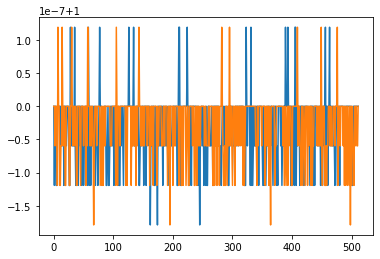

In [35]:
import matplotlib.pyplot as plt
test_eeg_features_avg2 = (test_eeg_features_avg - test_eeg_features_avg.mean(0))/ test_eeg_features_avg.std(0)
test_image_features_avg2 = (test_image_features_avg - test_image_features_avg.mean(0)) / test_image_features_avg.std(0)

# print(test_eeg_features_avg2.std(0))
# print(test_image_features_avg2.std(0))
plt.plot(np.arange(len(test_eeg_features_avg2[0])), test_eeg_features_avg2.std(0).cpu())
plt.plot(np.arange(len(test_image_features_avg2[0])), test_image_features_avg2.std(0).cpu())
plt.show()

In [36]:
evaluate(test_eeg_features_avg2, test_image_features_avg2)

Similarity Acc 0.6106122448979591


(0.6106122448979591,
 array([[ 0., -1., -1., ..., -1., -1.,  1.],
        [ 1.,  0.,  1., ...,  1.,  1.,  1.],
        [ 1., -1.,  0., ...,  1.,  1.,  1.],
        ...,
        [-1., -1., -1., ...,  0.,  1.,  1.],
        [ 1.,  1., -1., ..., -1.,  0.,  1.],
        [-1.,  1.,  1., ...,  1., -1.,  0.]]))

In [39]:
unit_corr = []
for i in range(val_image_features.shape[1]):
    corr = np.corrcoef(val_image_features[:,i].cpu(), val_eeg_features[:,i].cpu())[0,1]
    unit_corr.append(corr)

unit_indices = np.argsort(unit_corr)[::-1][:100]

target_latent = torch.cat([test_image_features_avg, val_image_features], axis=0)
target_latent_std =  target_latent.std(0)
target_latent_mean = target_latent.mean(0)

source_latent = test_eeg_features_avg
source_latent_std = source_latent.std(0)
source_latent_mean = source_latent.mean(0)
source_latent = (source_latent - source_latent_mean)/source_latent_std
source_latent = (source_latent * target_latent_std + target_latent_mean)
print('mean: ', target_latent_mean.mean(), source_latent_mean.mean())
print('std: ', target_latent_std.mean(), source_latent_std.mean())

source_latent = torch.from_numpy(source_latent.cpu().numpy()[:, unit_indices])# torch.from_numpy()
target_latent = torch.from_numpy(target_latent.cpu().numpy()[:,unit_indices])
acc, mat = evaluate(source_latent, target_latent)
print(mat)
print(mat[0])
print('acc', np.mean(np.sum(mat > 0, 1) / (len(target_latent)-1)))
print(np.sum(mat < 0, 1))
print('top1: ',  np.mean(np.sum(mat < 0, 1) < 1))
print('top5: ', np.mean(np.sum(mat < 0, 1) < 5))
print('top10: ', np.mean(np.sum(mat < 0, 1) < 10))


mean:  tensor(-0.0080, device='cuda:0') tensor(0.0028, device='cuda:0')
std:  tensor(1.0520, device='cuda:0') tensor(0.4702, device='cuda:0')
Similarity Acc 0.5775180144115292
[[ 0.  1.  1. ...  1.  1.  1.]
 [ 1.  0.  1. ...  1.  1.  1.]
 [-1.  1.  0. ...  1.  1. -1.]
 ...
 [ 1.  1.  1. ...  1.  1. -1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ... -1.  1.  1.]]
[0. 1. 1. ... 1. 1. 1.]
acc 0.5775180144115292
[   0   97  199   52  496  565  268  624  156  118   68  758  868  635
   11  408  909  400  259  116  268 1126  618  754  392  417 1225 1169
  882  768 1230  167 1124  604  766 1079  710  261 1189    4  866  209
  329  461  749  942  121  367  332  248]
top1:  0.02
top5:  0.04
top10:  0.04
